<a href="https://colab.research.google.com/github/jbarrasa/goingmeta/blob/main/session27/GoingMeta_27_Building_a_Reflection_Agent_with_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langchain langgraph langchain-openai

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from google.colab import userdata
import os

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')


#Actor 1:  A Modelling Expert

In [6]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a data modelling expert capable of creating high quality entity-relationship models from denormalised datasets. "
            "You always follow these modeling principles: "
            "You don't overnormalize the model. "
            "You don't use the same name for realtionships connecting different types of entities. "
            "You make sure that all features in the dataset are included in the model. "
            "You make sure there is a one to one mapping between the attributes in the extracted entities and the features in the dataset provided as input. ",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


llm = ChatOpenAI(model="gpt-4")

model_generate = prompt | llm

### Prompt for the Modelling Expert

In [7]:
# Utility function to retrieve the metadata from a Kaggle Dataset
import requests

def get_metadata_from_kaggle_croassant(usr_dataset):
   url = f"https://www.kaggle.com/datasets/{usr_dataset}/croissant/download"
   response = requests.get(url)
   if response.status_code == 200:
    data = response.json()
    # iterate over fields in the first record set
    return data["name"], data["description"], ", ".join(field["source"]["extract"]["column"] for field in data['recordSet'][0]['field'])

   else:
      return "" # or throw error?

In [8]:
def generate_prompt_for_kaggle_dataset(usr_dataset):

  task_description = "From the list of features in the dataset below, extract a list of entities and relationships with their attributes and map them to the features \
    in the dataset. The attributes don't need to be named after the features in the dataset, but they should be mapped to the corresponding feature name. \
    Give meaningful names to relationships rather than just a pair of entities. \
    In addition to that, for each entity, attribute and relationship, provide the closest schema.org term identified by its uri. \
    The output format should be as follows:  \
    {'entities': [ { 'name': 'the entity name', schema_org_term: 'uri of the closest schema.org term for the entity', 'attributes' : [ { 'name': 'the att name', schema_org_term: 'uri of the closest schema.org term for the attribute', 'mappedTo' : 'the feature name'}, ...]}, 'relationships': [ { 'name': 'the entity name', schema_org_term: 'uri of the closest schema.org term for the relationship', 'from': 'source entity', 'to': 'target entity'}]}  \
    Absolutely no extra text or comments, only json as output. \n\n"

  name, desc, features = get_metadata_from_kaggle_croassant(usr_dataset)

  metadata = f"DATASET NAME: {name} \n\nDATASET DESCRIPTION: {desc} \n\nDATASET FEATURES: {features} "

  prompt = task_description + metadata

  return prompt

### TESTING the Modelling Expert

In [9]:
# TESTING GENERATION
# Datasets:
# Supply Chain : "shashwatwork/dataco-smart-supply-chain-for-big-data-analysis"
# Crime data : "sahirmaharajj/crime-data-from-2020-to-present-updated-monthly"

model_as_text = ""
request = HumanMessage(
    content= generate_prompt_for_kaggle_dataset("shashwatwork/dataco-smart-supply-chain-for-big-data-analysis")
)
for chunk in model_generate.stream({"messages": [request]}):
    #print(chunk.content, end="")
    model_as_text += chunk.content


In [ ]:
print(model_as_text)

In [25]:
# Utility function to visualise a data model
from graphviz import Digraph

def generate_graph_viz_and_render(model_t, filename):
  model = eval(model_t)
  graph = Digraph(engine='neato',node_attr={'shape': 'Mrecord'}, format="png")

  for c in model['entities']:
      attnames = (x['name'] + "\n(sch:" + x['schema_org_term'][18:] + ") " for x in c['attributes'])
      graph.node(c['name'].replace(" ","_")+"_node",   "{ Entity: " + c['name']
                  + "\n(sch:" + c['schema_org_term'][18:] + ") " + "|" + "|".join(attnames) + "}")    #shape='ellipse')

  for r in model['relationships']:
      graph.edge(r['from'].replace(" ","_") + "_node",r['to'].replace(" ","_") + "_node",
                  label=r['name'] + "\n(sch:" + r['schema_org_term'][18:] + ") " , len='6.00')

  graph.render(filename)

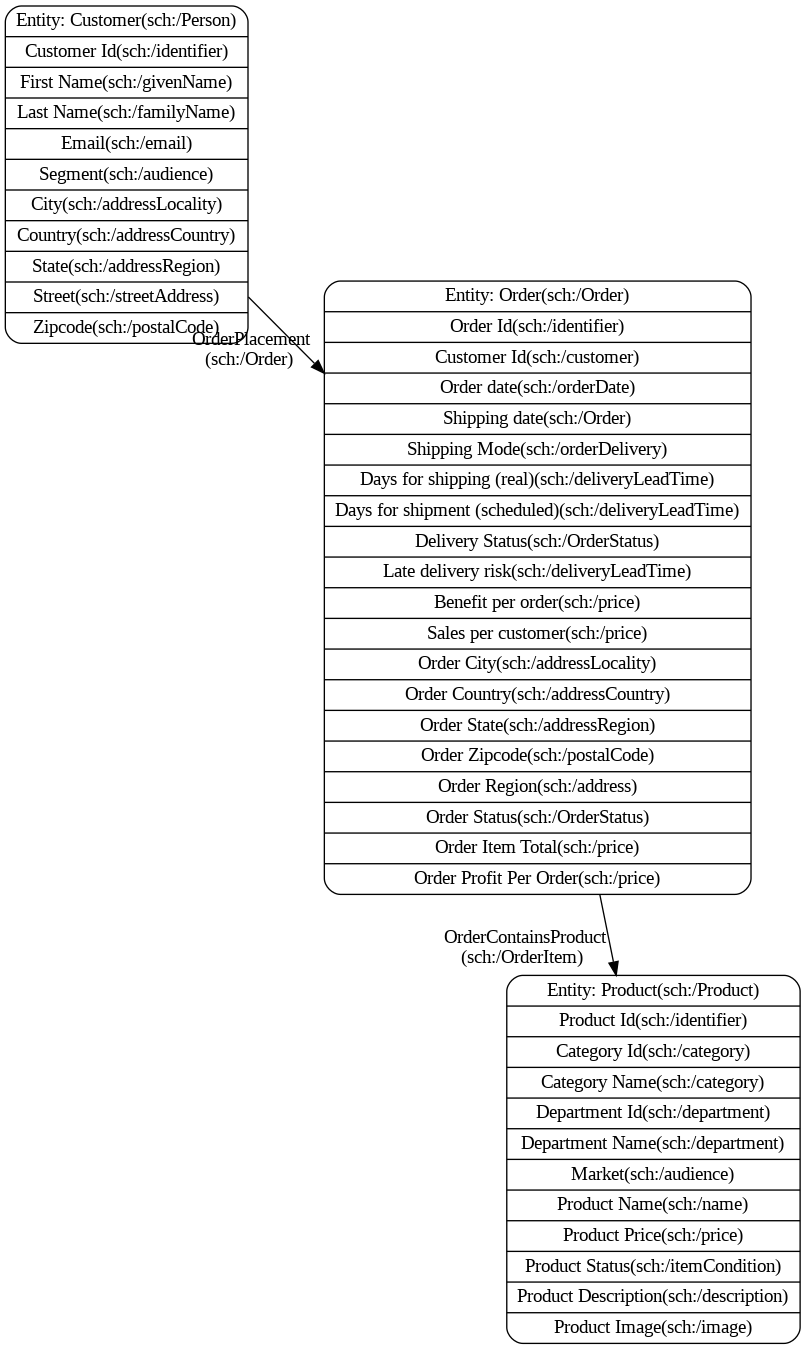

In [26]:
# Visualise the model generated in the previous test
from IPython.display import Image
filename = "model"
generate_graph_viz_and_render(model_as_text, filename)
Image(filename + ".png")

#Actor 2:  A Model reviewer (critic)

In [9]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a data modelling expert capable of analysing entity-relationship models and suggest changes that can improve them. " +
            "You are not supposed to generate a new model, just provide suggestions for changes when pertinent. " +
            "You always pay extra attention at the following: " +
            "Detect under-normalized in the model and recommend they are extracted as new entities connected to the existing ones through relevant relationships. " +
            "Detect over-normalized entities in the model and recommend they are merged as part of existing ones. " +
            "Suggest alternative names for terms (property names, entity names, relationship names) used in the model if the proposed ones are not adequate or expressive enough" +
            "You do not recommend combining or merging attributes into composite ones. " +
            "You don't always need to propose changes, if a model is good as-is just do not propose changes. "
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
model_reflect = reflection_prompt | llm

### Prompt for the Model reviewer

In [10]:
def generate_prompt_for_model_critique(current_model):
    task = "Analyse the entity-relationship model below and propose some changes in the form of concise instructions. No more than two or three changes. No preamble or additional comments at the end. The E-R model comes serialised as JSON including entities with their attributes and relationship connecting entities {'entities': [ { 'name': 'the entity name', schema_org_term: 'uri of the closest schema.org term for the entity', 'attributes' : [ { 'name': 'the att name', schema_org_term: 'uri of the closest schema.org term for the attribute', 'mappedTo' : 'the feature name'}, ...]}, 'relationships': [ { 'name': 'the entity name', schema_org_term: 'uri of the closest schema.org term for the relationship', 'from': 'source entity', 'to': 'target entity'}]}  \n\n MODEL:\n\n"
    prompt = task + current_model
    return task + current_model

### TESTING the Model Reviewer

In [11]:
critique = ""

for chunk in model_reflect.stream({"messages": [HumanMessage(content=generate_prompt_for_model_critique(model_as_text))]}):
    #print(chunk.content, end="")
    critique += chunk.content

In [12]:
print(critique)

1. Extract "Address" as a new entity from the "Customer" and "Order" entities. It seems that both "Customer" and "Order" entities have a series of attributes related to address (e.g., City, Country, State, Street, Zipcode). To avoid redundancy and enhance the structure, we could create a separate entity named "Address" with aforementioned attributes. Corresponding relationships "CustomerHasAddress" and "OrderHasAddress" need to be added.

2. Merge "ShippingDaysReal" and "ShippingDaysScheduled" attributes in the "Order" entity. These two attributes seem to be very closely related, both referring to the delivery lead time. Consider merging them into one attribute named "ShippingDays" with two properties: "real" and "scheduled". 

3. Rename "SalesPerCustomer" attribute in the "Order" entity to "OrderValue". The current name might be misleading as it implies a total sales value for a customer, whereas it's likely to represent the value of a particular order. 

4. Rename "Segment" attribute

#Actor 3:  A Model Changer / Editor

In [13]:
#GM27
model_change_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a data modelling expert capable of modifying entity-relationship models serialised as JSON. "
            "You apply some changes and then return the modified in the same format as the orignial one "
            "You apply exclusively the changes you're given and only the changes you're given. No more. "
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
model_change = model_change_prompt | llm

### Prompt for the Model changer

In [14]:
def generate_prompt_for_model_change(current_model, changes):
    task = f"Apply the following changes to the model below  \nCHANGES:\n {changes} \n\n No other changes than the ones listed and absolutely no extra text or comments, only JSON as output. MODEL:\n"
    return task + current_model

## Test it!

In [15]:
new_model_as_text = ""
for chunk in model_change.stream({"messages": [HumanMessage(content= generate_prompt_for_model_change(model_as_text, critique))]}):
    #print(chunk.content, end="")
    new_model_as_text += chunk.content

In [ ]:
print(new_model_as_text)

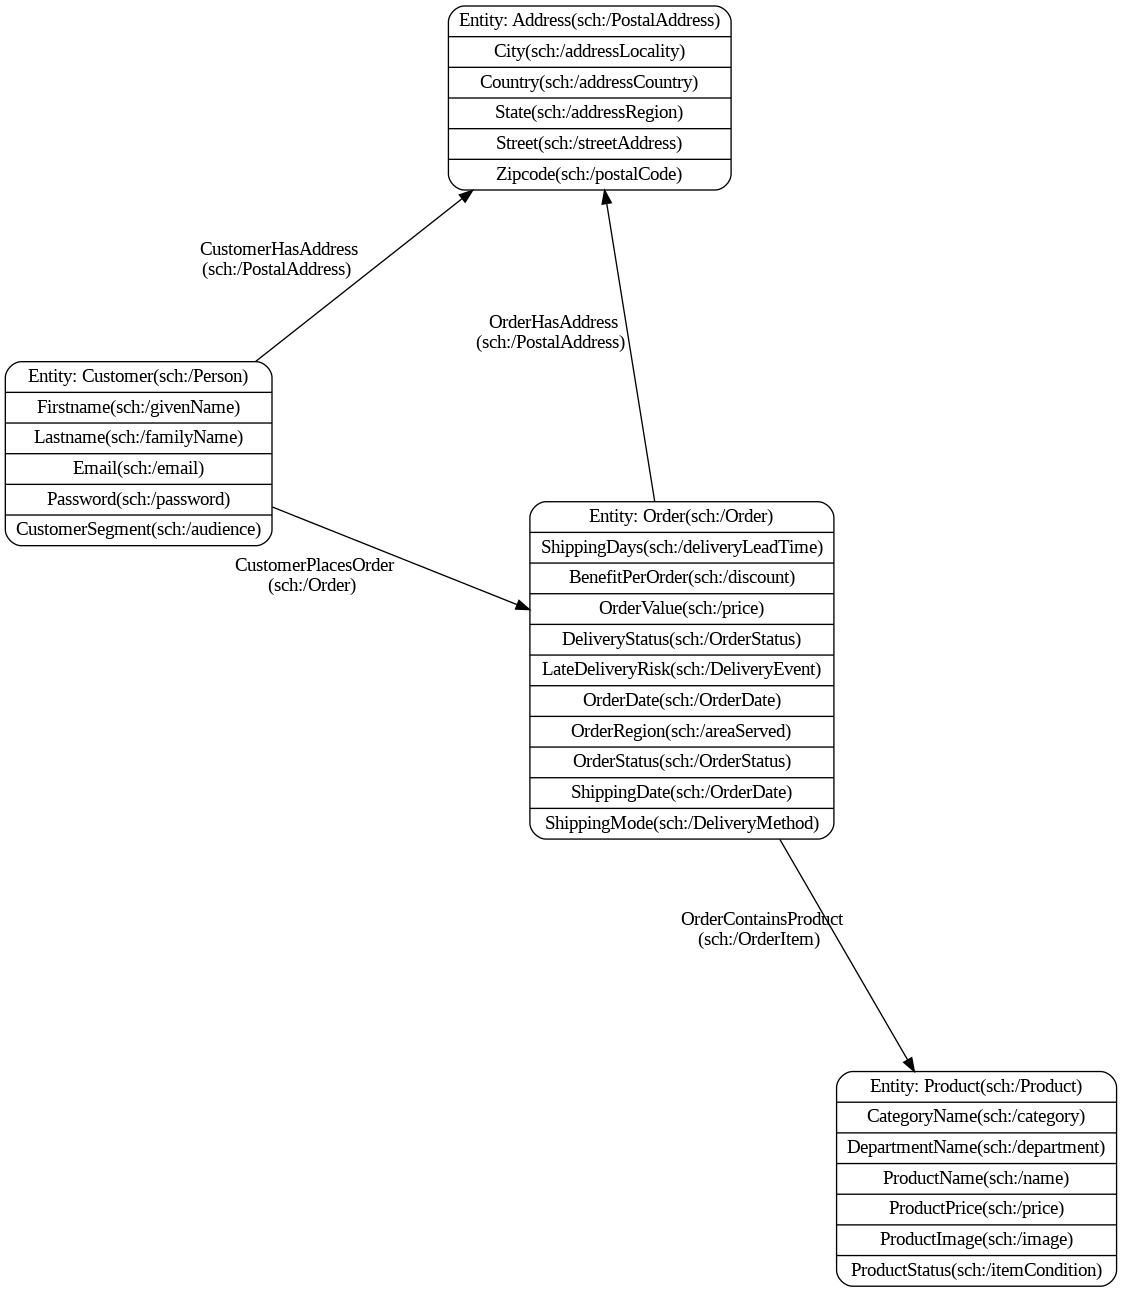

In [16]:
# Visualise the model generated in the previous test
filename = "nmodel"
generate_graph_viz_and_render(new_model_as_text, filename)
Image(filename + ".png")

#Building the app using LangGraph

In [ ]:
from typing import List, Sequence

from langgraph.graph import END, MessageGraph
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage

# mode of operation
human_in_the_loop_agent = False

async def model_generation_node(state: Sequence[BaseMessage]):
    return await model_generate.ainvoke({"messages": state})


async def model_reflection_node(state: Sequence[BaseMessage]) -> List[BaseMessage]:
    if (not human_in_the_loop_agent):
      current_model_msg = state[-1]
      res = await model_reflect.ainvoke({"messages": [HumanMessage(content= generate_prompt_for_model_critique(current_model_msg.content) )]})
      content = res.content
    else:
      content = input("feedback please: \n")
    return HumanMessage(content= content)

async def model_change_node(state: Sequence[BaseMessage]) -> List[BaseMessage]:
    changes_message = state[-1]
    current_model_msg = state[-2]
    res = await model_change.ainvoke({"messages": [HumanMessage(content= generate_prompt_for_model_change(current_model_msg.content, changes_message.content))]})
    return AIMessage(content=res.content)


builder = MessageGraph()
builder.add_node("model_generate", model_generation_node)
builder.add_node("model_reflect", model_reflection_node)
builder.add_node("model_change", model_change_node)
builder.set_entry_point("model_generate")


def should_i_iterate(state: List[BaseMessage]):
    if(human_in_the_loop_agent):
        # Human terminating the process
        feedback_message = state[-1]
        if len(feedback_message.content) > 0 :
            return "model_change"
    else:
        # n number of iterations
        if len(state) < 6 :
            return "model_change"
    return END

builder.add_edge("model_generate","model_reflect")
builder.add_conditional_edges("model_reflect", should_i_iterate)
builder.add_edge("model_change","model_reflect")
graph = builder.compile()

## and... let's test it!

In [ ]:
#GM27
# Datasets:
# Supply Chain : "shashwatwork/dataco-smart-supply-chain-for-big-data-analysis"
# Crime data : "sahirmaharajj/crime-data-from-2020-to-present-updated-monthly"

async for event in graph.astream(
    [
        HumanMessage(
            content= generate_prompt_for_kaggle_dataset("sahirmaharajj/crime-data-from-2020-to-present-updated-monthly")
        )
    ],
):
    print(event)
    print("---")

In [ ]:
for msg in event[END] :
  print(msg)

In [ ]:
diagram_filename = "model_viz"
generate_graph_viz_and_render(event[END][1].content, diagram_filename)
Image(diagram_filename + ".png")

In [ ]:
print("Feedback on previous model:\n" + event[END][2].content + "\n")
diagram_filename = "model_viz"
generate_graph_viz_and_render(event[END][3].content, diagram_filename)
Image(diagram_filename + ".png")

In [ ]:
print("Feedback on previous model:\n" + event[END][4].content + "\n")
diagram_filename = "model_viz"
generate_graph_viz_and_render(event[END][5].content, diagram_filename)
Image(diagram_filename + ".png")

In [ ]:
ChatPromptTemplate.from_messages(event[END]).pretty_print()